# SPX Volatility Term Structure Analysis

Click [here](https://github.com/jackliu234/spx-vol-term-struct/blob/master/project-lab.ipynb) to download this notebook. 

## Section 1: Packages

Import all relevant packages.

In [1]:
import sys
import json
import numpy as np
import scipy as sp
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from urllib.request import urlopen
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

## Section 2: Function

Define functions.

In [2]:
def yahoo_parser(url):
    response = urlopen(url)
    data = json.loads(response.read().decode("utf-8"))['chart']['result'][0]
    t = pd.to_datetime(data['timestamp'], unit='s').date
    c = data['indicators']['quote'][0]['close']
    return pd.DataFrame({'close': c}, index=t)


def default_parser(url):
    return pd.read_csv(url, index_col=0, parse_dates=True)


def retrieve(source, code, label, column=None):
    query = {
        'yahoo': 'https://query1.finance.yahoo.com/v8/finance/chart/{}?period1=0&period2=5000000000&interval=1d',
    }
    parser = {
        'yahoo': yahoo_parser,
    }
    url = query.get(source).format(code)
    df = parser.get(source, default_parser)(url)
    df.index.name = None
    df.columns = [col.lower() for col in df.columns] if df.shape[1] > 1 else [label]
    if not column: column = df.columns
    all_dates = pd.date_range(df.index.min(), df.index.max(), freq='D')
    df = df.replace('.', None).reindex(all_dates).fillna(method='ffill')
    return df.astype('float')[column].squeeze()

## Section 3: Data

Get data from yahoo.

In [3]:
# load yahoo data
raw_df = retrieve('yahoo', '^GSPC', 'SPX').to_frame()

In [4]:
raw_df

SPX
1970-01-02    93.000000
1970-01-03    93.000000
1970-01-04    93.000000
1970-01-05    93.459999
1970-01-06    92.820000
1970-01-07    92.629997
1970-01-08    92.680000
1970-01-09    92.400002
1970-01-10    92.400002
1970-01-11    92.400002
1970-01-12    91.699997
1970-01-13    91.919998
1970-01-14    91.650002
1970-01-15    91.680000
1970-01-16    90.919998
1970-01-17    90.919998
1970-01-18    90.919998
1970-01-19    89.650002
1970-01-20    89.830002
1970-01-21    89.949997
1970-01-22    90.040001
1970-01-23    89.370003
1970-01-24    89.370003
1970-01-25    89.370003
1970-01-26    88.169998
1970-01-27    87.620003
1970-01-28    86.790001
1970-01-29    85.690002
1970-01-30    85.019997
1970-01-31    85.019997
...                 ...
2019-03-25  2798.360107
2019-03-26  2818.459961
2019-03-27  2805.370117
2019-03-28  2815.439941
2019-03-29  2834.399902
2019-03-30  2834.399902
2019-03-31  2834.399902
2019-04-01  2867.189941
2019-04-02  2867.239990
2019-04-03  2873.399902
2019-04-04  2879.389893
2019-04-05  2892.739990
2019-04-06  2892.739990
2019-04-07  2892.739990
2019-04-08  2895.770020
2019-04-09  2878.199951
2019-04-10  2888.209961
2019-04-11  2888.320068
2019-04-12  2907.409912
2019-04-13  2907.409912
2019-04-14  2907.409912
2019-04-15  2905.580078
2019-04-16  2907.060059
2019-04-17  2900.449951
2019-04-18  2905.030029
2019-04-19  2905.030029
2019-04-20  2905.030029
2019-04-21  2905.030029
2019-04-22  2907.969971
2019-04-23  2933.949951

[18009 rows x 1 columns]

### Rolling moments

In [5]:
# remove all weekends
df = raw_df.copy()
df = df.reindex(pd.date_range(start="1970-01-02", end="2018-12-31", freq='B'))

# take the log price and return
df['log_SPX'] = np.log(df["SPX"])
df['r'] = df['log_SPX'] - df['log_SPX'].shift(1)
df['r_ann'] = df['r'] * 252

# define terms
# s = ' 7D, 15D, 30D, 45D, 60D, 90D, 120D, 150D, 180D,  240D, 300D, 360D, 450D, 540D, 720D '
# s = s.split(',')
# term = [x.strip() for x in s]
# term_n = [int(x[:-1]) for x in term ]
term_n = [7] + list(range(15, 721, 15))
term = [str(i)+"D" for i in term_n]
terms = dict(zip(term,term_n))

# calculate rolling volatilities
for k, v in terms.items(): 
    df['mean_'+ k ] = df["r"].rolling(v).mean() * 252
    df['vol_'+ k ] = df["r"].rolling(v).std() * np.sqrt(252)
    df['skew_' + k] = df["r"].rolling(v).skew()
    df['kurt_' + k] = df["r"].rolling(v).kurt()

# remove na
# df.fillna(value=0, inplace=True)

In [6]:
df

SPX   log_SPX         r      r_ann   mean_7D    vol_7D  \
1970-01-02    93.000000  4.532599       NaN        NaN       NaN       NaN   
1970-01-05    93.459999  4.537534  0.004934   1.243377       NaN       NaN   
1970-01-06    92.820000  4.530662 -0.006871  -1.731592       NaN       NaN   
1970-01-07    92.629997  4.528613 -0.002049  -0.516372       NaN       NaN   
1970-01-08    92.680000  4.529153  0.000540   0.135997       NaN       NaN   
1970-01-09    92.400002  4.526127 -0.003026  -0.762478       NaN       NaN   
1970-01-12    91.699997  4.518522 -0.007605  -1.916372       NaN       NaN   
1970-01-13    91.919998  4.520919  0.002396   0.603859 -0.420512  0.073689   
1970-01-14    91.650002  4.517977 -0.002942  -0.741289 -0.704035  0.057401   
1970-01-15    91.680000  4.518304  0.000327   0.082471 -0.444883  0.051911   
1970-01-16    90.919998  4.509980 -0.008324  -2.097718 -0.670790  0.065283   
1970-01-19    89.650002  4.495913 -0.014067  -3.544824 -1.196621  0.089523   
1970-01-20    89.830002  4.497919  0.002006   0.505461 -1.015487  0.098254   
1970-01-21    89.949997  4.499254  0.001335   0.336398 -0.693663  0.099229   
1970-01-22    90.040001  4.500254  0.001000   0.252025 -0.743925  0.096502   
1970-01-23    89.370003  4.492785 -0.007469  -1.882173 -0.906909  0.100232   
1970-01-26    88.169998  4.479267 -0.013518  -3.406621 -1.405350  0.111273   
1970-01-27    87.620003  4.473009 -0.006257  -1.576874 -1.330944  0.109811   
1970-01-28    86.790001  4.463491 -0.009518  -2.398510 -1.167185  0.097193   
1970-01-29    85.690002  4.450736 -0.012755  -3.214325 -1.698583  0.095186   
1970-01-30    85.019997  4.442886 -0.007850  -1.978119 -2.029228  0.076597   
1970-02-02    85.750000  4.451436  0.008550   2.154500 -1.757446  0.116875   
1970-02-03    86.769997  4.463261  0.011825   2.979853 -1.062871  0.162045   
1970-02-04    86.239998  4.457134 -0.006127  -1.543958 -0.796776  0.149836   
1970-02-05    85.900002  4.453184 -0.003950  -0.995459 -0.713717  0.148467   
1970-02-06    86.330002  4.458177  0.004993   1.258321 -0.191312  0.146539   
1970-02-09    87.010002  4.466023  0.007846   1.977166  0.550329  0.126464   
1970-02-10    86.099998  4.455509 -0.010514  -2.649449  0.454425  0.135992   
1970-02-11    86.940002  4.465218  0.009709   2.446633  0.496158  0.138561   
1970-02-12    86.730003  4.462800 -0.002418  -0.609429 -0.016597  0.121287   
...                 ...       ...       ...        ...       ...       ...   
2018-11-20  2641.889893  7.879250 -0.018318  -4.616135 -1.847507  0.184764   
2018-11-21  2649.929932  7.882288  0.003039   0.765745 -1.021782  0.169896   
2018-11-22  2649.929932  7.882288  0.000000   0.000000 -0.968393  0.171068   
2018-11-23  2632.560059  7.875712 -0.006576  -1.657258 -0.931681  0.170236   
2018-11-26  2673.449951  7.891125  0.015413   3.884070 -0.756183  0.188852   
2018-11-27  2682.169922  7.894381  0.003256   0.820609 -0.718904  0.190152   
2018-11-28  2743.790039  7.917095  0.022714   5.723941  0.702996  0.214712   
2018-11-29  2737.800049  7.914910 -0.002185  -0.550745  1.283766  0.163911   
2018-11-30  2760.169922  7.923048  0.008138   2.050662  1.467326  0.164080   
2018-12-03  2790.370117  7.933930  0.010882   2.742264  1.859078  0.160820   
2018-12-04  2700.060059  7.901029 -0.032900  -8.290858  0.911421  0.285768   
2018-12-05  2700.060059  7.901029  0.000000   0.000000  0.356553  0.273757   
2018-12-06  2695.949951  7.899506 -0.001523  -0.383894  0.184482  0.273909   
2018-12-07  2633.080078  7.875910 -0.023596  -5.946277 -1.482692  0.258306   
2018-12-10  2637.719971  7.877670  0.001761   0.443672 -1.340633  0.261741   
2018-12-11  2636.780029  7.877314 -0.000356  -0.089815 -1.646415  0.248000   
2018-12-12  2651.070068  7.882719  0.005405   1.362027 -1.843592  0.233605   
2018-12-13  2650.540039  7.882519 -0.000200  -0.050387 -0.666382  0.150966   
2018-12-14  2599.949951  7.863247 -0.019271  -4.856345 -1.360146  0.178549   
2018-12-17  2545.939941  7.842255 -0.02099

In [6]:
moment_table = pd.DataFrame(columns=['mean','std','skewness','kurtosis'], index=terms.keys())
for k, v in terms.items(): 
    moment_table.loc[k,'mean'] = np.mean(df["r"].rolling(v).mean() * 252)
    moment_table.loc[k,'std'] = np.mean(df["r"].rolling(v).std() * np.sqrt(252))
    moment_table.loc[k,'skewness'] = np.mean(df["r"].rolling(v).skew())
    moment_table.loc[k,'kurtosis'] = np.mean(df["r"].rolling(v).kurt())
moment_table.loc[:, 'window_len'] = list(terms.values())

In [8]:
moment_table

mean       std   skewness  kurtosis  window_len
7D    0.0644982  0.137434  0.0548599  0.216427           7
15D   0.0653414  0.141758  0.0176198  0.428163          15
30D   0.0666426  0.144208 -0.0334465  0.704094          30
45D   0.0671187   0.14551 -0.0746352  0.946517          45
60D   0.0674304  0.146438  -0.104589   1.14841          60
75D   0.0678638  0.147163  -0.124149    1.3216          75
90D   0.0684116  0.147792  -0.139158   1.48373          90
105D  0.0690498  0.148356  -0.153874   1.65042         105
120D  0.0694729  0.148812  -0.167598   1.80813         120
135D  0.0698429  0.149219  -0.179129    1.9573         135
150D  0.0700842   0.14959  -0.189432   2.09946         150
165D  0.0702742  0.149941  -0.198801   2.23783         165
180D  0.0703067   0.15027  -0.206998   2.37757         180
195D  0.0703221  0.150579  -0.214343   2.51689         195
210D  0.0703189  0.150866  -0.221484   2.65924         210
225D  0.0703679  0.151141  -0.228264    2.7987         225
240D  0.0703953  0.151395  -0.234671   2.93176         240
255D  0.0704054  0.151635  -0.240824   3.06553         255
270D  0.0703527  0.151874   -0.24729   3.20203         270
285D  0.0702613  0.152115   -0.25405   3.34289         285
300D  0.0701396   0.15235   -0.26028   3.47833         300
315D  0.0700148  0.152581  -0.266673   3.61523         315
330D  0.0698817  0.152812  -0.273532   3.75347         330
345D  0.0697244  0.153039  -0.280286   3.89064         345
360D  0.0695832  0.153265  -0.287008   4.03068         360
375D  0.0694835  0.153488  -0.293489   4.17044         375
390D  0.0693999  0.153711  -0.299987   4.31284         390
405D  0.0693203   0.15393  -0.306479   4.45685         405
420D  0.0692791  0.154147   -0.31306   4.60233         420
435D  0.0692112  0.154358  -0.319157   4.74515         435
450D   0.069139  0.154569  -0.325362   4.89127         450
465D  0.0690829  0.154783  -0.331552   5.03935         465
480D  0.0690656  0.154996  -0.337655   5.18752         480
495D  0.0690642  0.155209  -0.343811   5.33835         495
510D  0.0690256  0.155423  -0.350089   5.49316         510
525D  0.0689581  0.155636  -0.356251   5.64787         525
540D  0.0688876  0.155848  -0.362193   5.80088         540
555D  0.0688025  0.156061  -0.368151   5.95609         555
570D  0.0686994  0.156274  -0.374303   6.11524         570
585D  0.0686065  0.156487  -0.380589   6.27721         585
600D  0.0685155  0.156697  -0.386902   6.44009         600
615D  0.0684497  0.156905  -0.393298   6.60508         615
630D  0.0683814   0.15711  -0.399791   6.77096         630
645D  0.0683208  0.157314  -0.406331   6.93801         645
660D  0.0682515  0.157515  -0.412771   7.10697         660
675D  0.0681916  0.157711  -0.419245   7.27915         675
690D   0.068115  0.157907  -0.425742   7.45301         690
705D   0.068052  0.158101  -0.432327   7.62845         705
720D  0.0679965  0.158294  -0.438941    7.8054         720

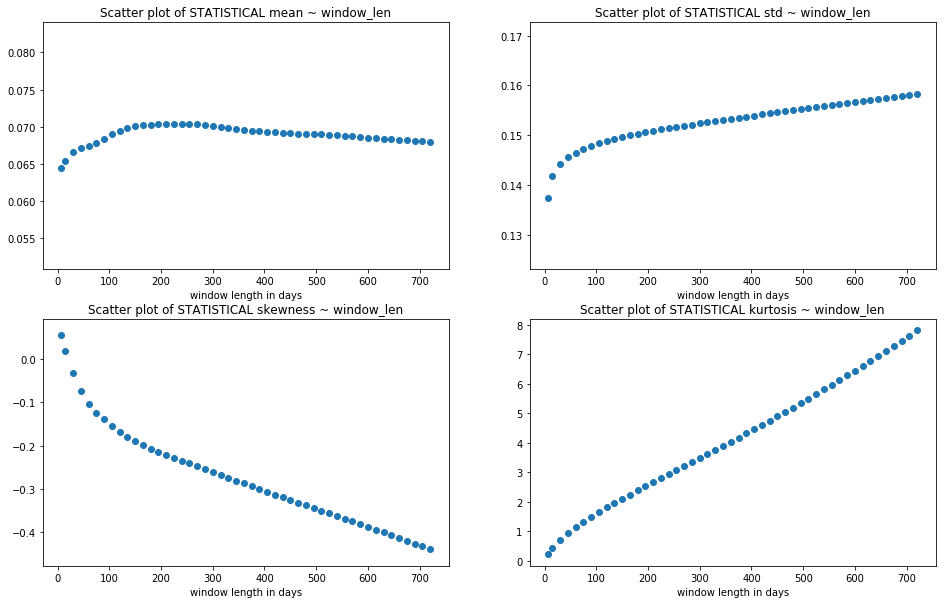

In [12]:
moment_names = ['mean', 'std', 'skewness', 'kurtosis']
plt.figure(figsize=(16, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(moment_table.window_len.values, moment_table[moment_names[i]].values)
    plt.title('Scatter plot of STATISTICAL '+moment_names[i]+" ~ window_len")
    plt.xlabel("window length in days")

### Non-rolling moments

In [8]:
df_nonr = df.copy()  # non-rolling results

In [9]:
nonr_moments_table = pd.DataFrame()
nonr_moments_dict = {}  # key: window_length, value: dataframe of moments
for term, window_len in terms.items():
    keep_columns = ['log_SPX', 'r', 'r_ann'] + [i + "_" + term for i in['mean', 'vol', 'skew', 'kurt']]
    tmp_df = df_nonr.loc[:, keep_columns].dropna()
    keep_rows = list(range(window_len-1, len(tmp_df), window_len))
    tmp_df = tmp_df.iloc[keep_rows, :]
    nonr_moments_dict.update({window_len: tmp_df})
    tmp_moments = (tmp_df.iloc[:, 3:].mean()).values.tolist()
    tmp_df = pd.DataFrame([[window_len] + tmp_moments], index=[term], columns=['window_len', 'mean', 'std', 'skewness', 'kurtosis'])
    nonr_moments_table = pd.concat([nonr_moments_table, tmp_df], axis=0)

In [10]:
nonr_moments_dict

{7:              log_SPX         r     r_ann   mean_7D    vol_7D   skew_7D  \
 1970-01-21  4.499254  0.001335  0.336398 -0.693663  0.099229 -1.222410   
 1970-01-30  4.442886 -0.007850 -1.978119 -2.029228  0.076597  0.991576   
 1970-02-10  4.455509 -0.010514 -2.649449  0.454425  0.135992 -0.367836   
 1970-02-19  4.474606  0.003653  0.920548  0.687472  0.096072  0.908448   
 1970-03-02  4.496582  0.002344  0.590590  0.791150  0.102906  1.057358   
 1970-03-11  4.485147 -0.000676 -0.170417 -0.411662  0.085822 -0.431205   
 1970-03-20  4.466598 -0.004127 -1.039893 -0.667788  0.082018 -0.113217   
 1970-03-31  4.495690  0.000000  0.000000  1.047332  0.133869  1.465941   
 1970-04-09  4.483341  0.000452  0.113888 -0.444549  0.061311  0.553826   
 1970-04-20  4.452369  0.001866  0.470215 -1.115022  0.066095  0.095246   
 1970-04-29  4.404399  0.019004  4.788893 -1.726890  0.197548  1.861029   
 1970-05-08  4.375002 -0.004897 -1.234131 -1.058307  0.184855 -0.880793   
 1970-05-19  4.323603 

In [11]:
nonr_moments_table

window_len      mean       std  skewness  kurtosis
7D             7  0.065259  0.137105  0.071734  0.223070
15D           15  0.065528  0.141872  0.017287  0.390565
30D           30  0.066346  0.144470 -0.028764  0.674559
45D           45  0.065691  0.145681 -0.081718  0.937238
60D           60  0.065786  0.146654 -0.087789  1.086016
75D           75  0.068774  0.147687 -0.120374  1.299489
90D           90  0.068305  0.147842 -0.136248  1.425885
105D         105  0.073233  0.147334 -0.141286  1.445112
120D         120  0.072712  0.148229 -0.164338  1.708997
135D         135  0.073315  0.149007 -0.196740  1.976698
150D         150  0.071090  0.149670 -0.195905  2.239534
165D         165  0.072731  0.148919 -0.157448  2.061674
180D         180  0.068184  0.149855 -0.235848  2.432588
195D         195  0.070924  0.150816 -0.235001  2.680188
210D         210  0.070679  0.150701 -0.203165  2.460840
225D         225  0.070577  0.151862 -0.216480  2.787491
240D         240  0.070380  0.150591 -0.213289  2.746699
255D         255  0.068684  0.151442 -0.227092  2.838692
270D         270  0.069535  0.151339 -0.239346  2.918313
285D         285  0.069514  0.151593 -0.221129  2.937085
300D         300  0.068105  0.153405 -0.235306  3.324677
315D         315  0.067312  0.153074 -0.279155  3.559498
330D         330  0.068631  0.153123 -0.242511  3.802606
345D         345  0.065923  0.153205 -0.269568  3.639203
360D         360  0.067535  0.154338 -0.325717  4.260599
375D         375  0.067212  0.154792 -0.308157  4.250941
390D         390  0.067794  0.155266 -0.298061  4.845350
405D         405  0.068782  0.155421 -0.347158  4.941407
420D         420  0.068982  0.154973 -0.281243  4.453492
435D         435  0.068513  0.154837 -0.336891  4.571484
450D         450  0.068644  0.155107 -0.343590  4.676421
465D         465  0.069330  0.155706 -0.416999  6.194409
480D         480  0.069380  0.155510 -0.292606  4.750286
495D         495  0.069867  0.156558 -0.345524  5.223063
510D         510  0.068138  0.156062 -0.386113  5.570148
525D         525  0.068010  0.156653 -0.379639  5.572528
540D         540  0.067019  0.156827 -0.358220  5.476164
555D         555  0.066869  0.156755 -0.414582  5.778252
570D         570  0.068642  0.157024 -0.399139  6.516571
585D         585  0.065856  0.158809 -0.436844  6.870981
600D         600  0.067342  0.158961 -0.362230  6.391454
615D         615  0.067001  0.158533 -0.365329  6.345351
630D         630  0.067385  0.158550 -0.454272  6.957124
645D         645  0.065879  0.159595 -0.419862  7.127704
660D         660  0.069686  0.158170 -0.442994  7.423590
675D         675  0.065460  0.162286 -0.441180  8.186235
690D         690  0.066369  0.158714 -0.391499  6.920633
705D         705  0.068689  0.158222 -0.452612  7.211592
720D         720  0.065665  0.161069 -0.429440  7.523050

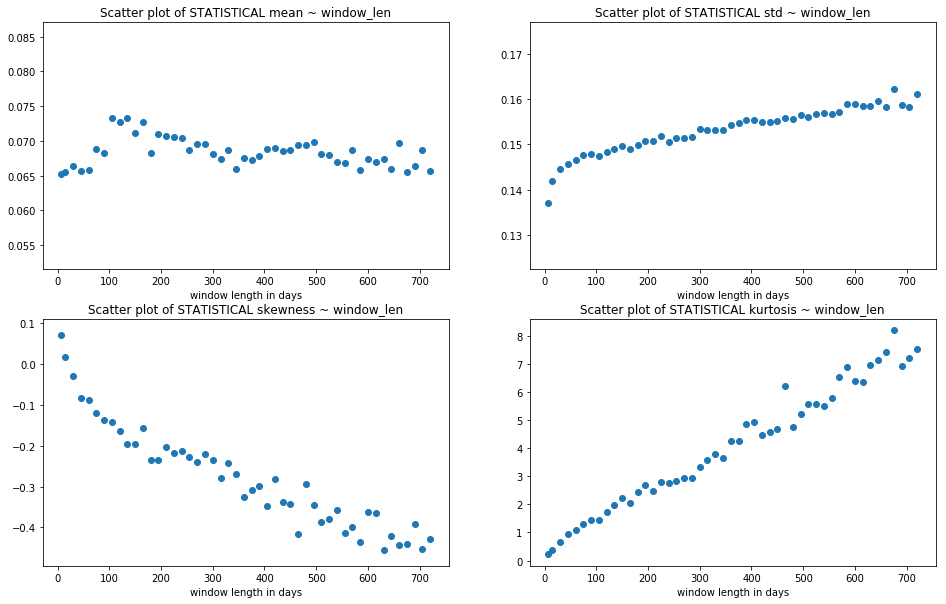

In [13]:
moment_names = ['mean', 'std', 'skewness', 'kurtosis']
plt.figure(figsize=(16, 10))
for i in range(4):
    plt.subplot(2, 2, i+1)
    plt.scatter(nonr_moments_table.window_len.values, nonr_moments_table[moment_names[i]].values)
    plt.title('Scatter plot of STATISTICAL '+moment_names[i]+" ~ window_len")
    plt.xlabel("window length in days")

In [81]:
# # calculate non-overlapping rolling volatilities
# weekly_moments = pd.DataFrame()
# monthly_moments = pd.DataFrame()
# sixmonth_moments = pd.DataFrame()
# oneyear_moments = pd.DataFrame()
# moments = {'W':weekly_moments,
#         'M':monthly_moments,
#         '3M':sixmonth_moments,
#         'Y':oneyear_moments}
# for k, v in moments.items():
#     v['non_rolling_mean_'+ str(k)] = df.groupby(pd.Grouper(freq=k))["r"].mean()
#     v['non_rolling_vol_'+ str(k)] = df.groupby(pd.Grouper(freq=k))["r"].std() * np.sqrt(252)
#     v['non_rolling_skew_'+ str(k)] = df.groupby(pd.Grouper(freq=k))["r"].skew()
#     v['non_rolling_kurt_'+ str(k)] = df.groupby(pd.Grouper(freq=k))["r"].apply(pd.Series.kurtosis)

In [82]:
# for i in moments.values():
#     print(i)

            non_rolling_mean_W  non_rolling_vol_W  non_rolling_skew_W  \
1970-01-04                 NaN                NaN                 NaN   
1970-01-11           -0.001294           0.069571            0.340237   
1970-01-18           -0.003229           0.075082            0.027770   
1970-01-25           -0.003439           0.112623           -1.059690   
1970-02-01           -0.009980           0.049461           -0.059993   
1970-02-08            0.003058           0.124044           -0.237974   
1970-02-15            0.000486           0.131824           -0.139240   
1970-02-22            0.003414           0.086252            1.386277   
1970-03-01            0.003312           0.125837            0.924067   
1970-03-08           -0.000134           0.072053           -0.060144   
1970-03-15           -0.003565           0.078782           -0.209837   
1970-03-22           -0.001829           0.096423           -0.763694   
1970-03-29            0.006465           0.143796  

# Section 4: Analysis

### Time Series Plot

In [15]:
cmap = ['#ff0000', '#ff7a00', '#f6ad48', '#c4c6bd', '#3193d8', '#005684']

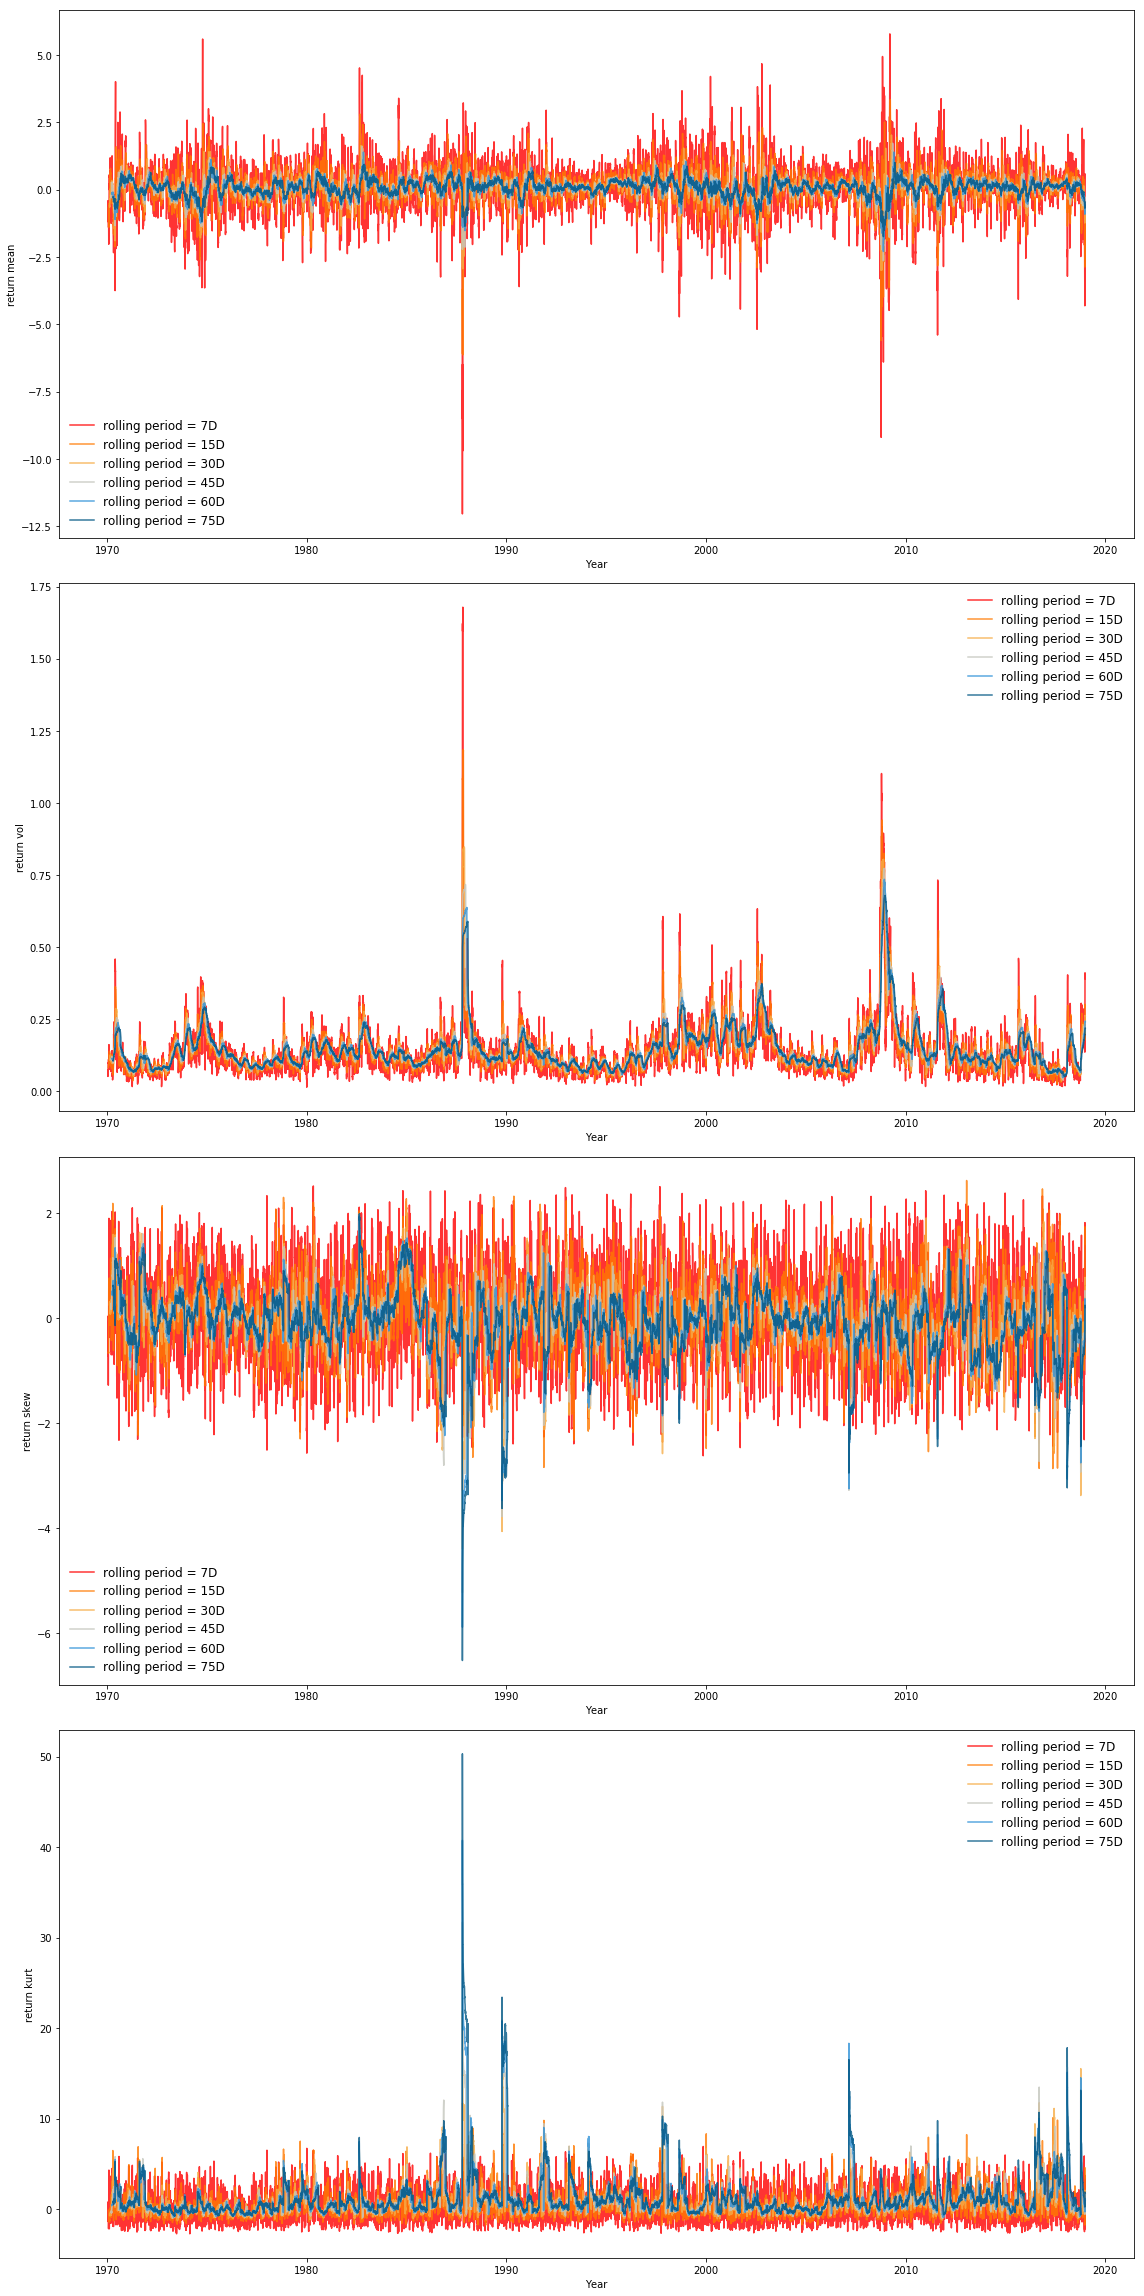

In [17]:
# too many windows, only display six
fig = plt.figure(figsize=(16, 32))
index = 1
for moment in ['mean', 'vol', 'skew', 'kurt']: 
    ax = fig.add_subplot(4, 1, index)
    cint = 0
    for term in terms.keys():
        ax.plot(df[moment+"_"+term], color=cmap[cint], label='rolling period = '+term, alpha=.8)
        cint += 1
        if cint==6:
            break
    plt.xlabel('Year')
    plt.ylabel('return '+moment)
    plt.legend(frameon=False, prop={'size': 12})
    plt.tight_layout()
    index += 1

### Empirical Distribution of Rolling Moments

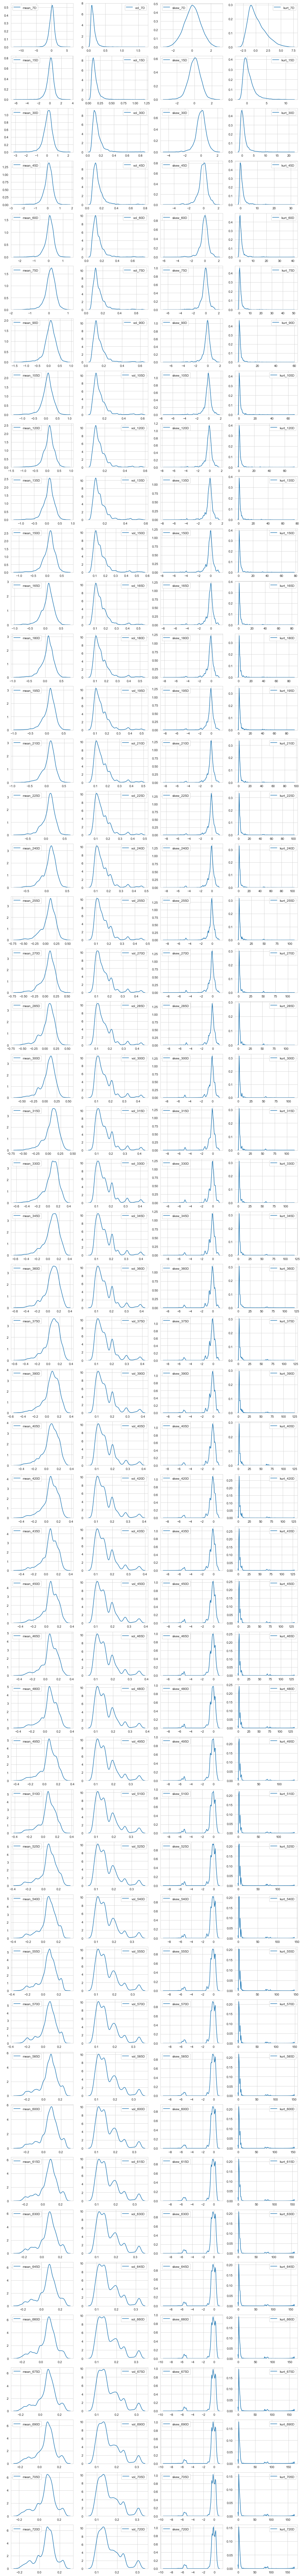

In [25]:
num_window = len(terms)
sns.set_style('whitegrid')
fig = plt.figure(figsize=(16, num_window*3))

index = 1
for term in terms:
    for i in ['mean_', 'vol_', 'skew_', 'kurt_']:
        plt.subplot(num_window, 4, index)
        sns.kdeplot(df[i+term])
        index += 1

### Time Series Plot of Non-Rolling Moments

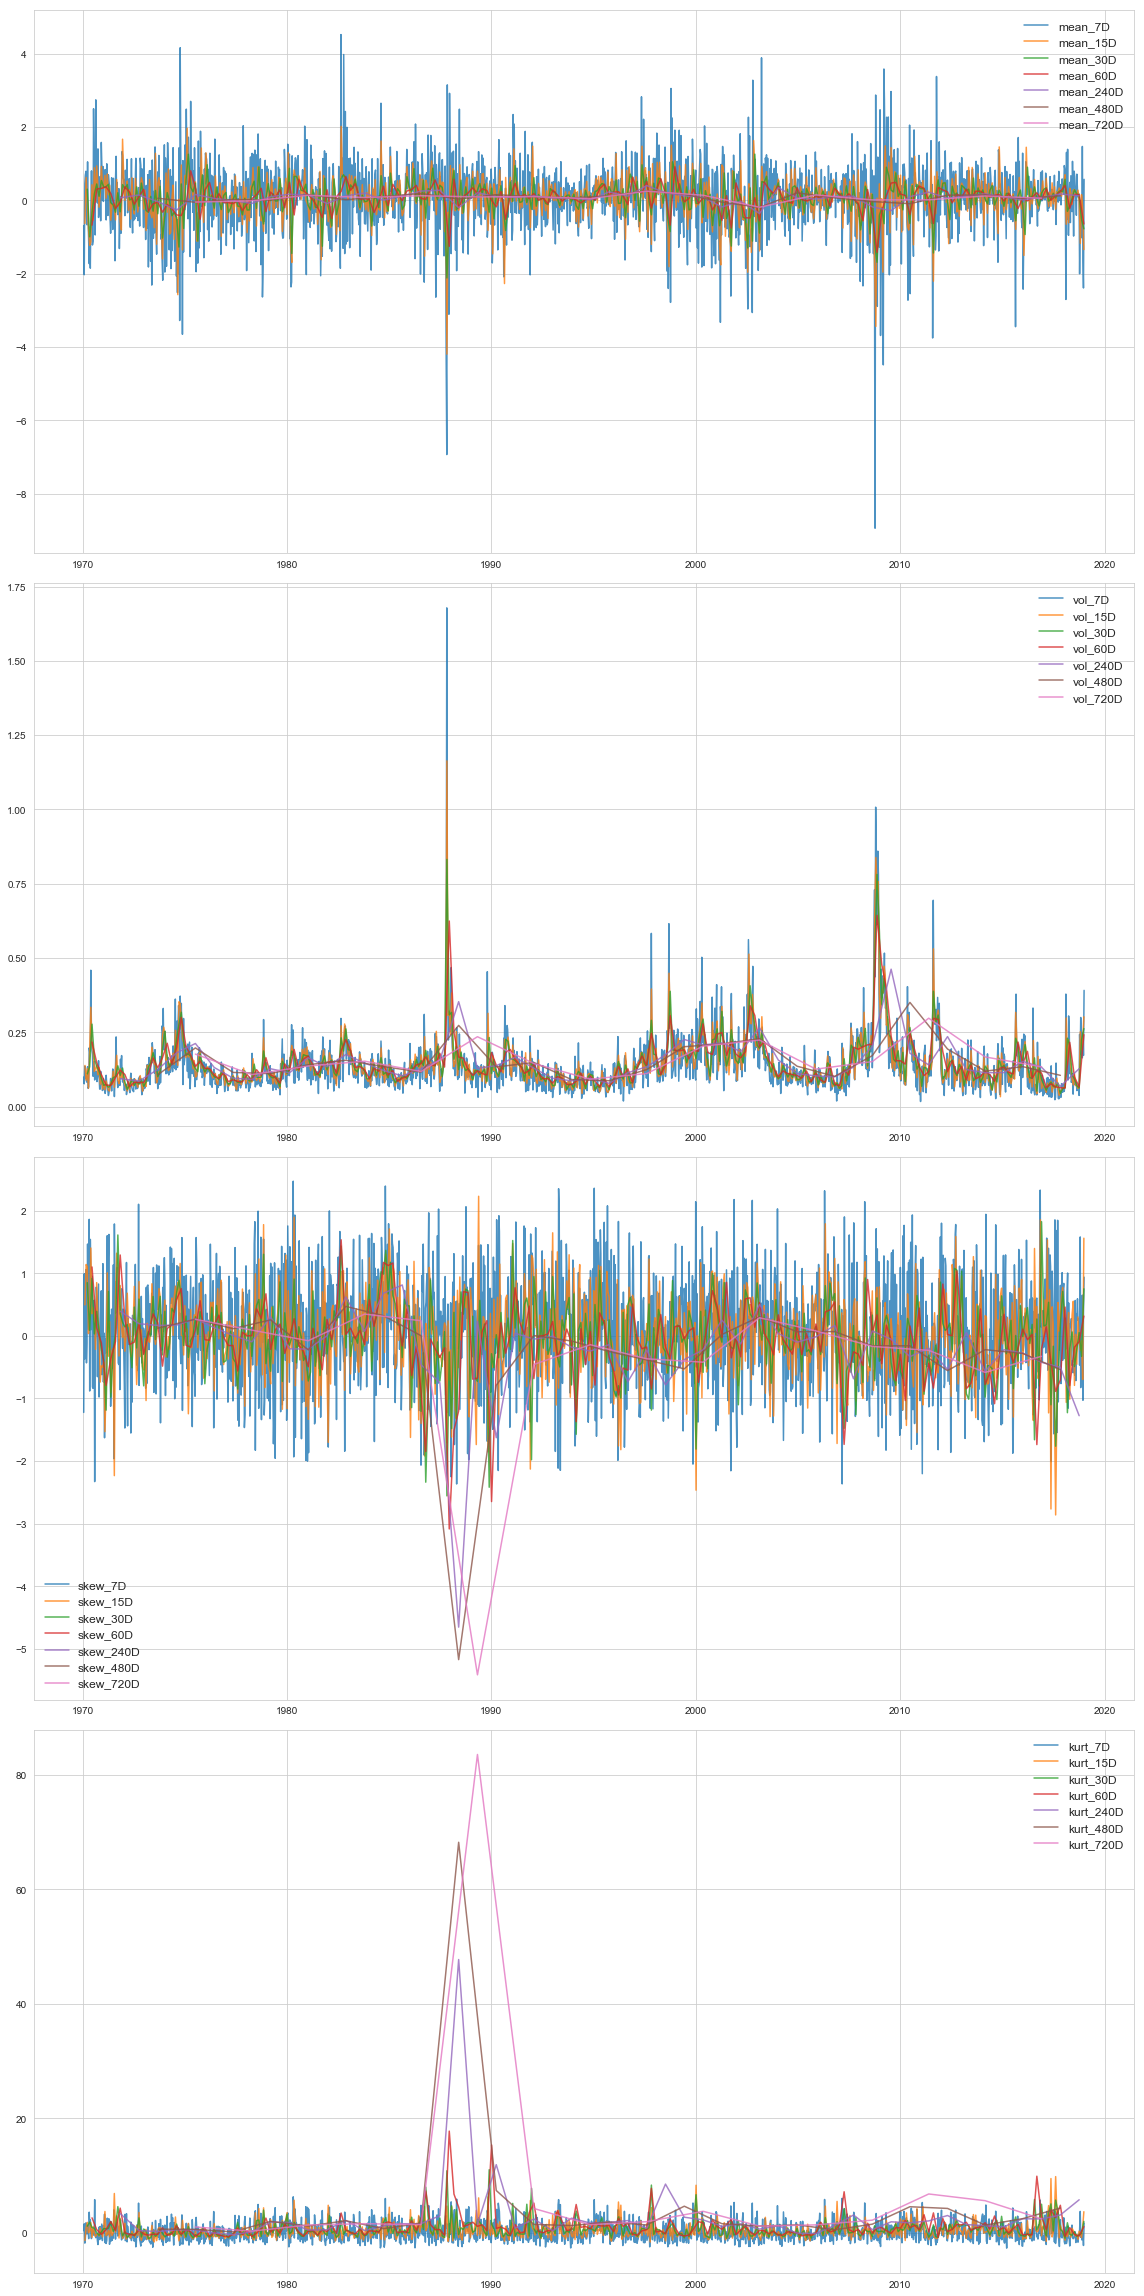

In [51]:
fig2, ax = plt.subplots(4, 1, figsize=(16, 32))
m = ['mean', 'vol', 'skew', 'kurt']
for i in range(1, 5): 
    for v in [list(nonr_moments_dict.values())[k] for k in [0, 1, 2, 4, 16, 32, 48]]:
        ax[i-1].plot(v.index, v.iloc[:, i+2], alpha=.8, label=v.columns[i+2])
        ax[i-1].legend(frameon=False, prop={'size': 12})
        plt.tight_layout()

Text(0.5, 1.0, 'Distribution of return mean')

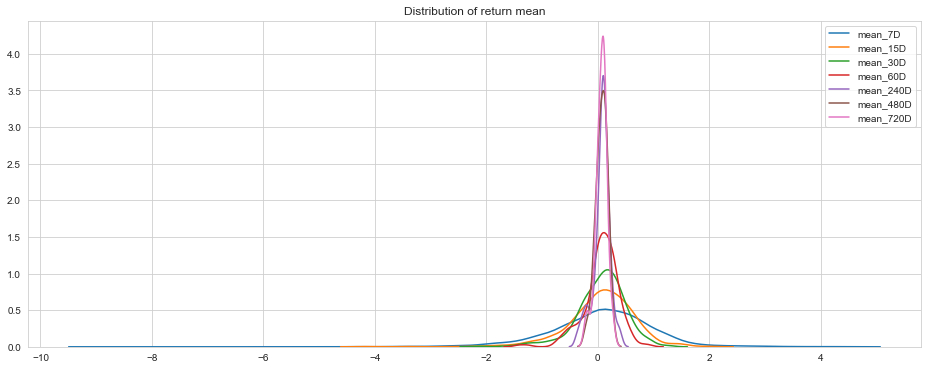

In [52]:
sns.set_style('whitegrid')
plt.figure(figsize=(16, 6))
for v in [list(nonr_moments_dict.values())[k] for k in [0, 1, 2, 4, 16, 32, 48]]:
    sns.kdeplot(v.iloc[:, i-1])
plt.title('Distribution of return mean')

In [54]:
# fig,ax = plt.subplots(4,1,figsize=(10,10),sharex=True)
# ax[0].plot(nonr_moments_table.index, nonr_moments_table['mean'])
# ax[1].plot(nonr_moments_table.index, nonr_moments_table['std'])
# ax[2].plot(nonr_moments_table.index, nonr_moments_table['skewness'])
# ax[3].plot(nonr_moments_table.index, nonr_moments_table['kurtosis'])
# ax[0].set_title('return mean')
# ax[1].set_title('return std')
# ax[2].set_title('return skewness')
# ax[3].set_title('return kurtosis')

# Plotted in Section 3

# Section 5: Fitting (Rolling Moments)

### Fewer Window Tried

In [15]:
from scipy.optimize import curve_fit
def func1(x, a, b):
    return a + b * x
def func2(x, a, b, c):
    return a + b * x + c * x ** 2

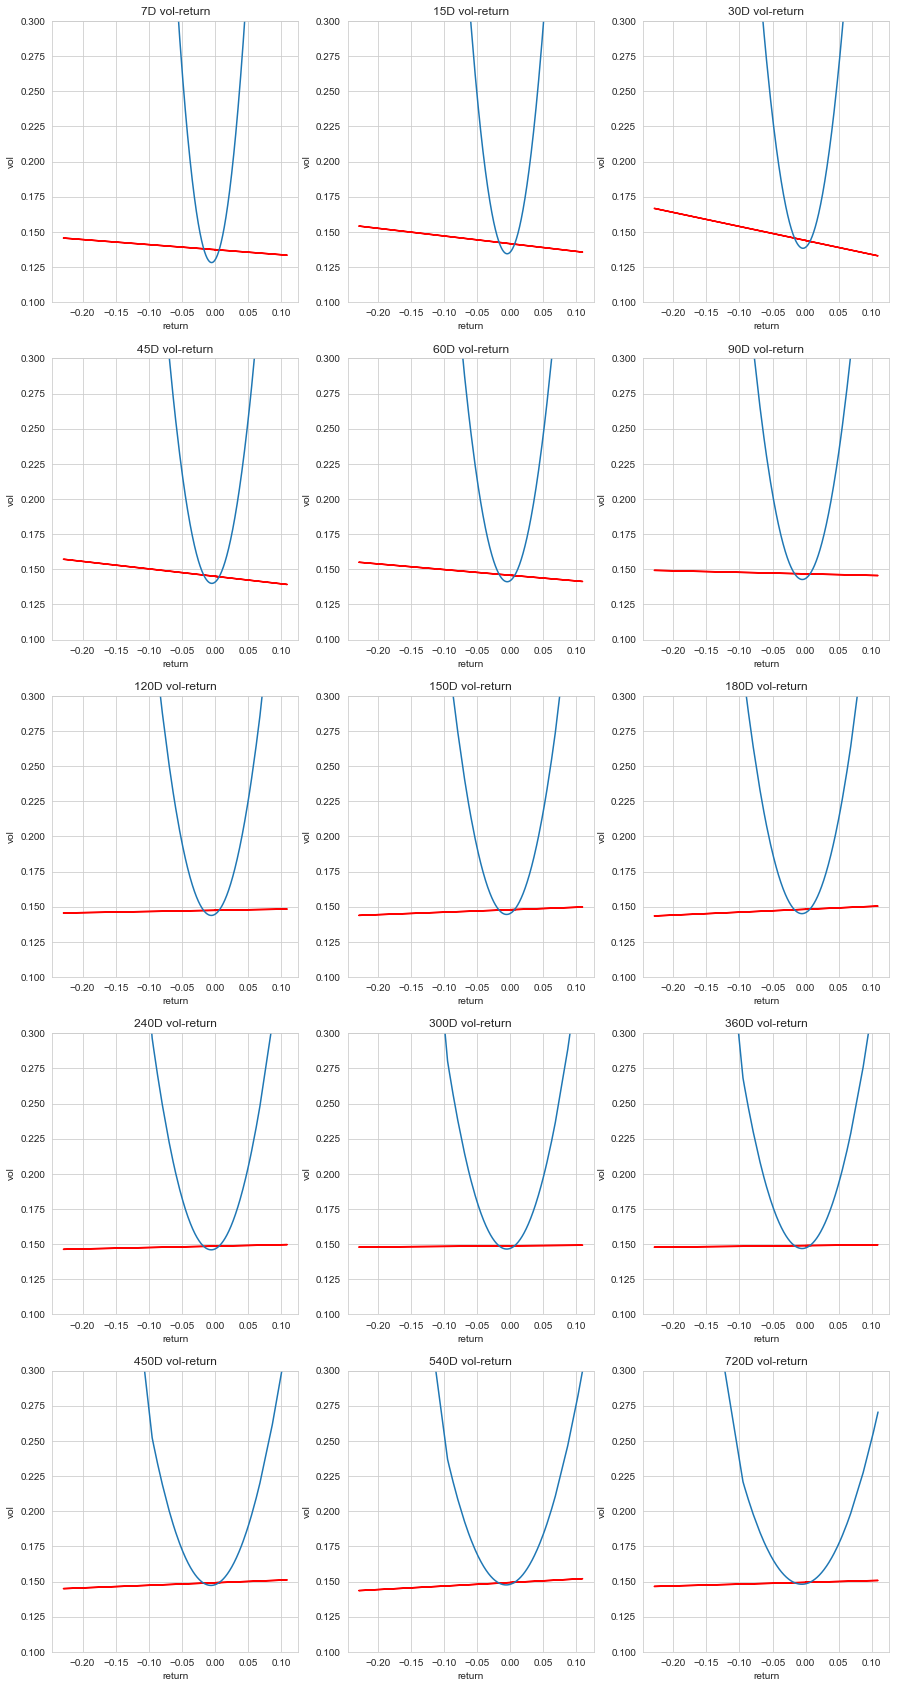

In [123]:
# i, j = 0, 0
# para = {}
# fig, ax = plt.subplots(len(terms)//3+int(len(terms)%3>0), 3, figsize=(15, 2*len(terms)))
# for k in terms.keys():
#     popt1, pcov1 = curve_fit(func1, df.r,df['vol_'+k])
#     popt2, pcov2 = curve_fit(func2, df.r,df['vol_'+k])
#     para[k]=[popt1, popt2]
#     ax[i][j].plot(df.r, func1(df.r, *popt1), 'r-')
#     ax[i][j].plot(pd.Series(sorted(df.r)), func2(pd.Series(sorted(df.r)), *popt2))
#     ax[i][j].set_ylim(0.1, 0.3)
#     ax[i][j].set_xlabel('return')
#     ax[i][j].set_ylabel('vol')################ vol at t: vol[t-term,t] or vol[t,t+term]
#     ax[i][j].set_title(k+' vol-return')
#     if j<2:
#         j=j+1
#     elif j==2:
#         i,j=i+1,0
# para=pd.DataFrame.from_dict(para,orient='index',columns=['a+bx','a+bx+cx^2'])       

In [124]:
# para

a+bx  \
7D     [0.13736772334887568, -0.03592526211108682]   
15D    [0.14160608720969536, -0.05470149502356891]   
30D     [0.1438954112413123, -0.09966684845835644]   
45D     [0.1450118239580637, -0.05302141365899645]   
60D    [0.14576127266256833, -0.04036162681748201]   
90D   [0.14675376306919685, -0.010905496392038083]   
120D   [0.14741284089121176, 0.008246443586978236]   
150D     [0.147829685458012, 0.017487498079354014]   
180D   [0.14814829925770823, 0.020608013385112867]   
240D    [0.1485499611317126, 0.009907044956385946]   
300D  [0.14877279017069944, 0.0039689068586312715]   
360D   [0.14894731494619462, 0.005095844308336206]   
450D   [0.14912287403952157, 0.018246807492334295]   
540D   [0.14925786487764742, 0.025010644139165542]   
720D   [0.14937395303381096, 0.012548438601097556]   

                                              a+bx+cx^2  
7D    [0.12974471741615531, 0.6567346469636471, 68.5...  
15D   [0.13555671147932957, 0.494971349323586, 54.42...  
30D   [0.13901128712903837, 0.34412590116913555, 43....  
45D   [0.14071059039460554, 0.3378080758378856, 38.6...  
60D   [0.14185313822813914, 0.3147485851326054, 35.1...  
90D   [0.14343656556516143, 0.29050957672835737, 29....  
120D  [0.14449657608423086, 0.27323101920291026, 26....  
150D  [0.14518432563789765, 0.25785643173505857, 23....  
180D  [0.1457215527580826, 0.2411127926915706, 21.83...  
240D  [0.14645540973887122, 0.2002270892820017, 18.8...  
300D  [0.14691855209563875, 0.17245307224968853, 16....  
360D  [0.14726342286310903, 0.15810164385455125, 15....  
450D  [0.14764733072978953, 0.15232113330503402, 13....  
540D  [0.1479914229513594, 0.1400851627459174, 11.39...  
720D  [0.14834998089857981, 0.1055910534269984, 9.21...

### More Window Size Tried (interval = 15D)

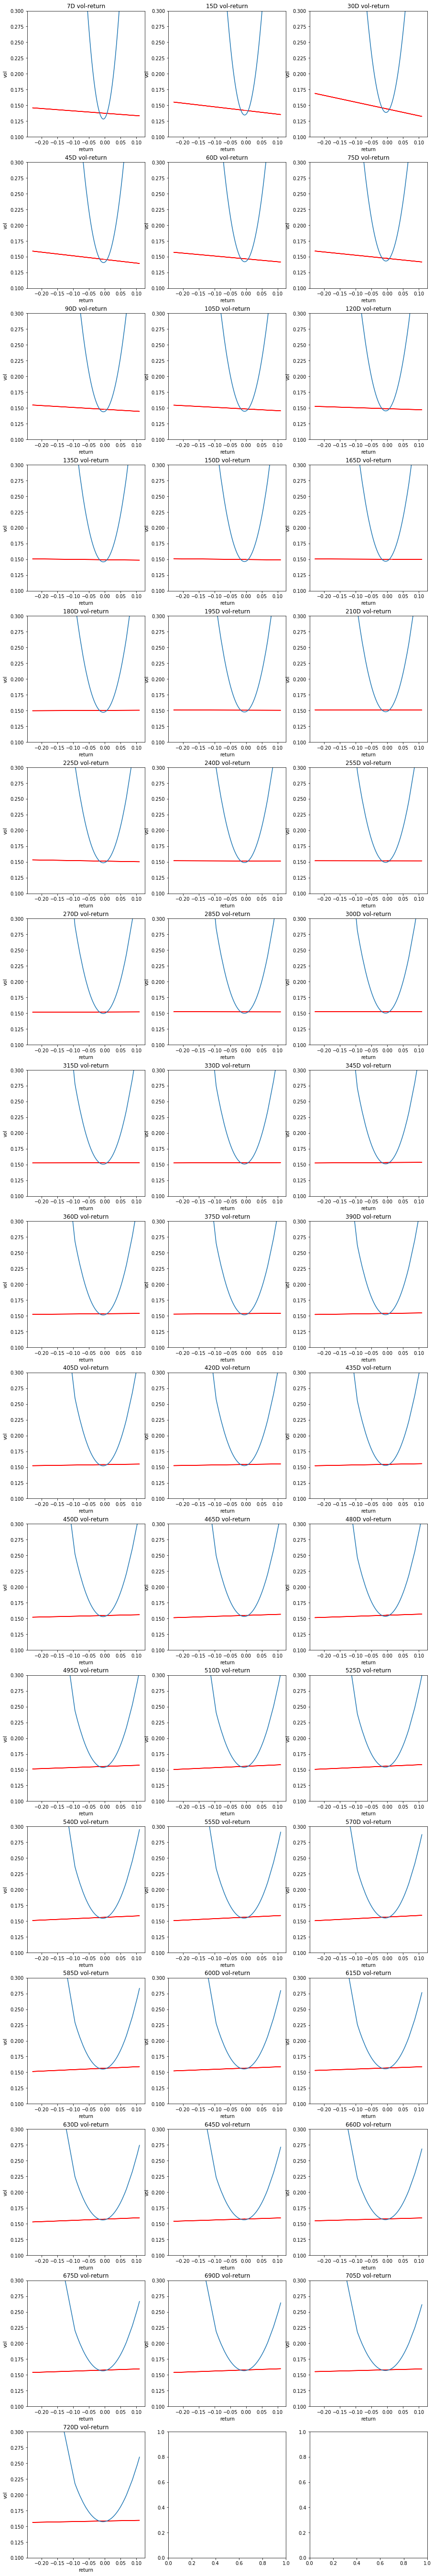

In [16]:
i, j = 0, 0
col_names = ['linear_mean', 'linear_skew', 'quad_mean', 'quad_skew', 'quad_kurt']
para = pd.DataFrame()
fig, ax = plt.subplots(len(terms)//3+int(len(terms)%3>0), 3, figsize=(15, 2*len(terms)))
for k in terms.keys():
    tmp_df = df.loc[:, ['r', 'vol_'+k]].dropna()
    popt1, pcov1 = curve_fit(func1, tmp_df.r, tmp_df['vol_'+k])
    popt2, pcov2 = curve_fit(func2, tmp_df.r, tmp_df['vol_'+k])
#     para[k] = [popt1, popt2]
    tmp_para = pd.DataFrame([list(popt1) + list(popt2)], index=[k], columns=col_names)
    para = pd.concat([para, tmp_para], axis=0)
    ax[i][j].plot(tmp_df.r, func1(tmp_df.r, *popt1), 'r-')
    ax[i][j].plot(pd.Series(sorted(tmp_df.r)), func2(pd.Series(sorted(tmp_df.r)), *popt2))
    ax[i][j].set_ylim(0.1, 0.3)
    ax[i][j].set_xlabel('return')
    ax[i][j].set_ylabel('vol')################ vol at t: vol[t-term,t] or vol[t,t+term]
    ax[i][j].set_title(k+' vol-return')
    if j < 2:
        j = j + 1
    elif j == 2:
        i, j = i + 1, 0

In [18]:
para

linear_mean  linear_skew  quad_mean  quad_skew  quad_kurt  window_len
7D       0.137443    -0.037503   0.129819   0.655033  68.562731           7
15D      0.141774    -0.058423   0.135723   0.490896  54.376832          15
30D      0.144237    -0.107857   0.139353   0.335609  43.861351          30
45D      0.145526    -0.057768   0.141227   0.332615  38.590862          45
60D      0.146450    -0.045652   0.142546   0.309106  35.028603          60
75D      0.147177    -0.051030   0.143607   0.273109  31.989702          75
90D      0.147800    -0.029776   0.144491   0.270734  29.641357          90
105D     0.148364    -0.026494   0.145271   0.258105  27.780883         105
120D     0.148817    -0.016191   0.145892   0.253879  26.282497         120
135D     0.149221    -0.005980   0.146432   0.251987  25.067286         135
150D     0.149591    -0.005635   0.146938   0.239976  23.841462         150
165D     0.149941    -0.002371   0.147402   0.232701  22.805502         165
180D     0.150269     0.002367   0.147836   0.228028  21.851056         180
195D     0.150579    -0.001218   0.148244   0.215409  20.963430         195
210D     0.150866    -0.000864   0.148626   0.206986  20.099443         210
225D     0.151143    -0.008862   0.148984   0.191378  19.360427         225
240D     0.151396    -0.001799   0.149305   0.192138  18.739844         240
255D     0.151635    -0.000604   0.149616   0.186523  18.080617         255
270D     0.151873     0.001662   0.149923   0.182354  17.454757         270
285D     0.152115    -0.000552   0.150229   0.173979  16.860099         285
300D     0.152350     0.000056   0.150513   0.169915  16.405357         300
315D     0.152581     0.000519   0.150798   0.165423  15.922838         315
330D     0.152811     0.001492   0.151074   0.161977  15.494774         330
345D     0.153039     0.002813   0.151345   0.159130  15.091907         345
360D     0.153264     0.004380   0.151615   0.156473  14.679364         360
375D     0.153487     0.003670   0.151885   0.151360  14.250756         375
390D     0.153709     0.007241   0.152149   0.150938  13.858520         390
405D     0.153928     0.007484   0.152401   0.148022  13.552453         405
420D     0.154145     0.007996   0.152650   0.145614  13.259728         420
435D     0.154355     0.009617   0.152895   0.144459  12.950052         435
450D     0.154566     0.011840   0.153146   0.142921  12.582014         450
465D     0.154779     0.015937   0.153395   0.143615  12.252279         465
480D     0.154992     0.016541   0.153650   0.140321  11.867254         480
495D     0.155204     0.017434   0.153903   0.137398  11.495062         495
510D     0.155417     0.022341   0.154159   0.138561  11.119720         510
525D     0.155630     0.022140   0.154402   0.135572  10.848842         525
540D     0.155843     0.021924   0.154655   0.131605  10.487704         540
555D     0.156055     0.023829   0.154905   0.129954  10.146531         555
570D     0.156268     0.025233   0.155154   0.127900   9.815617         570
585D     0.156481     0.022799   0.155399   0.122466   9.525156         585
600D     0.156692     0.019456   0.155639   0.116395   9.263517         600
615D     0.156900     0.017333   0.155874   0.111732   9.017143         615
630D     0.157105     0.019590   0.156101   0.111899   8.816209         630
645D     0.157310     0.015658   0.156328   0.105840   8.610657         645
660D     0.157511     0.013234   0.156553   0.101184   8.393731         660
675D     0.157707     0.016599   0.156769   0.102633   8.207895         675
690D     0.157902     0.017673   0.156987   0.101596   8.005154         690
705D     0.158098     0.012720   0.157203   0.094661   7.813842         705
720D     0.158291     0.009636   0.157410   0.090297   7.688379         720

### Plot of Term Structure
rolling moments ~ TTM

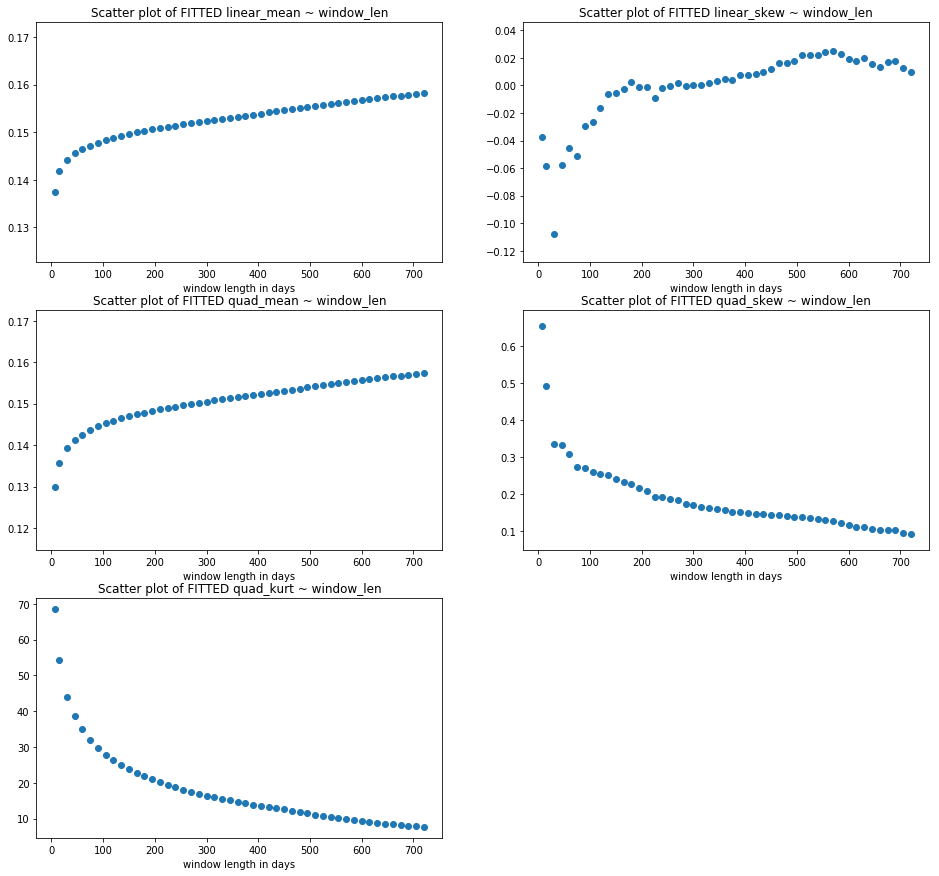

In [19]:
col_names = ['linear_mean', 'linear_skew', 'quad_mean', 'quad_skew', 'quad_kurt']
para.loc[:, 'window_len'] = terms.values()
plt.figure(figsize=(16, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.scatter(para.window_len.values, para[col_names[i]].values)
    plt.title('Scatter plot of FITTED '+col_names[i]+" ~ window_len")
    plt.xlabel("window length in days")

# Fitting (Non-Rolling Moments)

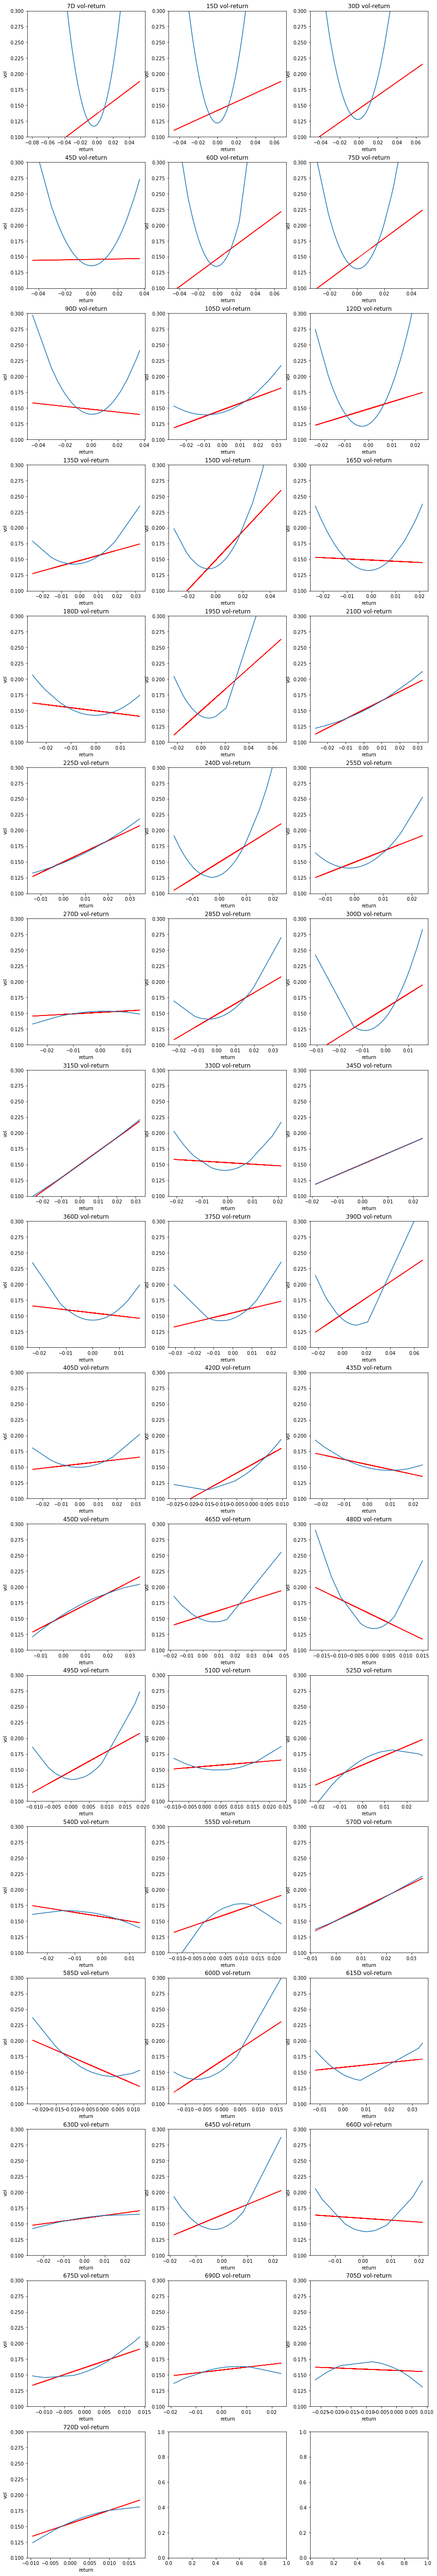

In [21]:
i, j = 0, 0
col_names = ['linear_mean', 'linear_skew', 'quad_mean', 'quad_skew', 'quad_kurt']
nonr_para = pd.DataFrame()
fig, ax = plt.subplots(len(terms)//3+int(len(terms)%3>0), 3, figsize=(15, 2*len(terms)))
for k, v in terms.items():
    tmp_df = nonr_moments_dict[v].loc[:, ['r', 'vol_'+k]].dropna()
    popt1, pcov1 = curve_fit(func1, tmp_df.r, tmp_df['vol_'+k])
    popt2, pcov2 = curve_fit(func2, tmp_df.r, tmp_df['vol_'+k])
#     para[k] = [popt1, popt2]
    tmp_para = pd.DataFrame([list(popt1) + list(popt2)], index=[k], columns=col_names)
    nonr_para = pd.concat([nonr_para, tmp_para], axis=0)
    ax[i][j].plot(tmp_df.r, func1(tmp_df.r, *popt1), 'r-')
    ax[i][j].plot(pd.Series(sorted(tmp_df.r)), func2(pd.Series(sorted(tmp_df.r)), *popt2))
    ax[i][j].set_ylim(0.1, 0.3)
    ax[i][j].set_xlabel('return')
    ax[i][j].set_ylabel('vol')################ vol at t: vol[t-term,t] or vol[t,t+term]
    ax[i][j].set_title(k+' vol-return')
    if j < 2:
        j = j + 1
    elif j == 2:
        i, j = i + 1, 0

In [23]:
nonr_para

linear_mean  linear_skew  quad_mean  quad_skew   quad_kurt
7D       0.136661     0.970782   0.119226   1.268002  170.621283
15D      0.141810     0.688833   0.121934   0.059931  200.542516
30D      0.144186     1.062286   0.127767   0.306211  149.622828
45D      0.145664     0.034973   0.135560  -0.014547  102.597454
60D      0.146730     1.114557   0.134712   0.258814  122.778085
75D      0.146768     1.601508   0.130705  -0.198822  189.238275
90D      0.147927    -0.225419   0.140014  -0.081742   77.398431
105D     0.146923     1.060613   0.142800   0.816479   44.816769
120D     0.148317     1.140940   0.123865   2.168275  393.880631
135D     0.147890     0.816388   0.142984   0.461890   73.671197
150D     0.148428     2.307374   0.137617   1.047594   99.331724
165D     0.148710    -0.190255   0.132456   0.492010  209.780727
180D     0.149675    -0.489144   0.142533   0.015158   99.825225
195D     0.149466     1.696399   0.141462  -1.023912   77.937693
210D     0.151150     1.439767   0.149674   1.425260   14.641437
225D     0.149799     1.673107   0.148472   1.421728   17.584292
240D     0.149621     2.638169   0.128286   1.956384  335.322140
255D     0.149203     1.785325   0.140688   0.597252  173.057642
270D     0.151246     0.231218   0.153063   0.104667  -27.442842
285D     0.147529     1.748569   0.142180   0.757727   86.040832
300D     0.157909     2.271792   0.142482   4.508477  254.381512
315D     0.149957     2.128685   0.149489   2.086701    4.194734
330D     0.152895    -0.244098   0.140793   0.319653  154.077564
345D     0.150628     1.715652   0.150603   1.713788    0.401113
360D     0.154655    -0.487914   0.143034  -0.025170  178.558507
375D     0.154578     0.733647   0.145393   1.145197   94.939312
390D     0.152685     1.276439   0.144957  -1.605199   65.072672
405D     0.154918     0.336725   0.149678   0.036282   49.261420
420D     0.153698     2.692840   0.145824   3.887490  116.863266
435D     0.154123    -0.783480   0.149200  -0.905494   44.742469
450D     0.153444     1.822160   0.155844   2.216958  -23.675514
465D     0.154301     0.821189   0.147753  -0.936044   65.761736
480D     0.155583    -2.573444   0.133985  -0.523087  512.219923
495D     0.147396     3.161629   0.134615  -0.488646  408.179055
510D     0.155271     0.420267   0.151063  -0.832690   98.320590
525D     0.157284     1.496345   0.165820   2.035027  -65.958190
540D     0.156804    -0.690345   0.159974  -0.988538  -38.079832
555D     0.151473     1.760034   0.155792   4.324369 -214.992433
570D     0.150307     1.958906   0.150193   1.725143    9.742302
585D     0.153115    -2.124844   0.145123  -0.983138  136.905023
600D     0.168484     3.801589   0.153081   4.135119  299.201644
615D     0.157900     0.380192   0.146759  -2.005977  100.123456
630D     0.158543     0.439004   0.159458   0.450185   -9.357521
645D     0.163439     1.694139   0.142552   1.281573  216.561113
660D     0.158437    -0.298305   0.137646  -0.534695  203.462476
675D     0.161262     2.146214   0.154157   2.191048  135.873645
690D     0.157733     0.459828   0.161320   0.571313  -40.282233
705D     0.157056    -0.195126   0.159231  -2.355779 -111.876810
720D     0.154207     2.098610   0.155855   2.669082  -71.808535

### Plot of Term Structure
non-rolling moments ~ TTM
- When window size is large, there are not enough data points to estimate a curve with confidence.

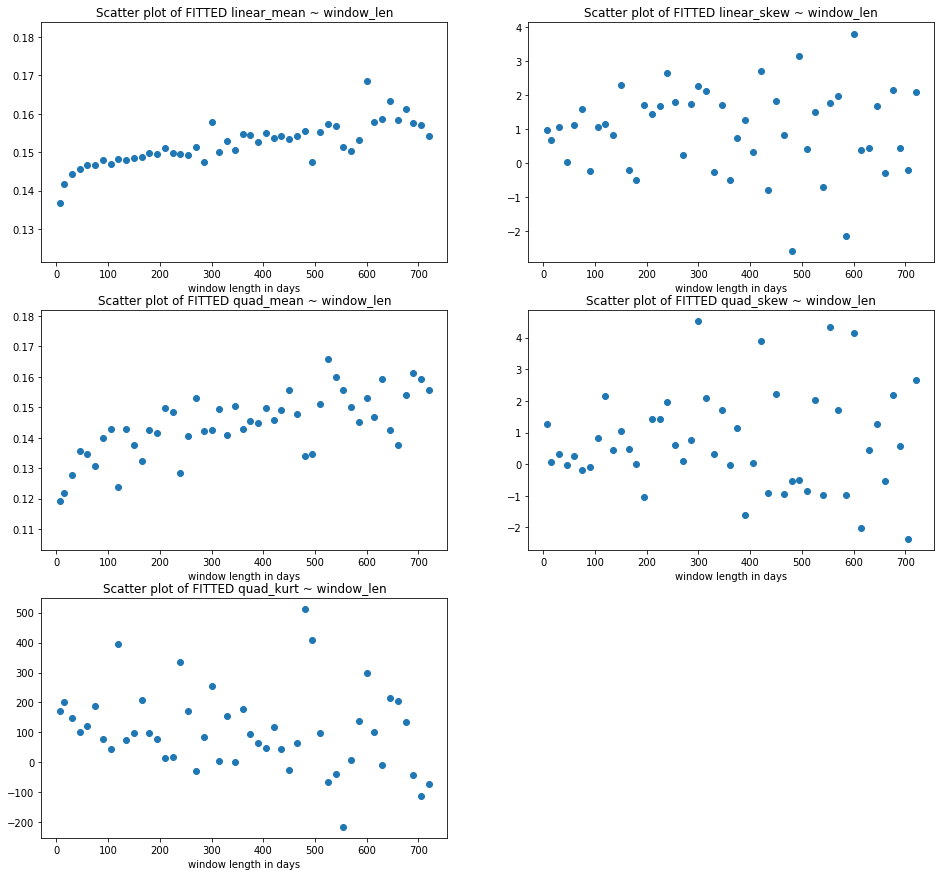

In [24]:
col_names = ['linear_mean', 'linear_skew', 'quad_mean', 'quad_skew', 'quad_kurt']
nonr_para.loc[:, 'window_len'] = terms.values()
plt.figure(figsize=(16, 15))
for i in range(5):
    plt.subplot(3, 2, i+1)
    plt.scatter(nonr_para.window_len.values, nonr_para[col_names[i]].values)
    plt.title('Scatter plot of FITTED '+col_names[i]+" ~ window_len")
    plt.xlabel("window length in days")

### Plot of Volatility Surface???